This notebook contains the project for Complex system simulation, Complex financial networks

In [245]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import sys
import os
import time
import datetime
import pickle
import argparse
import itertools
from typing import List, Tuple
import doctest
import pandas as pd
import powerlaw
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

# Financial contract network

Agent (nodes) want to enter into contracts with other agents (Links) to reduce their risk exposure. We will simulate what happens over time, studying when a total system collapse becomes more likely to occur as a function of the size of perturbation to the system.

1. There are total of $N$ Agents (nodes) and the i'th agent will have an exposure $e_i$ which initialized as a random number between 1 and -1.

2. Agents try to minimize their exposure by forming a link to another agent with opposite expsure, meaning finding another node with the opposite sign of $e_i$, namely $e_j$ such that the sum of their exposures $\Sigma e$ is as close to 0 as possible. A link is formed if $\Sigma e$ is minimal, if $\Sigma e$ is above a threshold, $T_e$, such that $\Sigma e$ > $T_e$ no link will be formed. 

We have to options for the link weights- Option B: The link weight is equal to the previous exposure of the node, and links are always biirectional but carry different weights. Thus the link weights become: $W$ is a weight function, so that $W(L_{ij}) = e_{ij}$ and $W(L_{ji}) = e_{ji}$ 

3. Each timestep the exposure of an agent is a brownian motion. Agents have exposure to the price of stock. We assume all agents have exposure to the same asset for simplicity. 

Agents have total volatility $V$, which is $e$ times the prive movement $S$, $e * S = V$. If V $<$ or $>$ threshold value $T_v$, an agent becomes bankrupt and also dies (meaning the node gets removed). This causes all links $L_{ij}$ to be removed and the values of the weights $W_{L_{ij}}$ to be added $e_{j}$ which is the exposure of $N_{j}$, which then increases the chances of $e_{j} > T_e$ and $N_{j}$ dying as a result, causing the effect to propagate.

- Hypothesis is that an increased average move away from the mean causes a higher probability of default when the number of links is higher



Limitations: 
- Bank only link at most twice, which is unrealistic as banks have more transactions
- There is only 1 asset

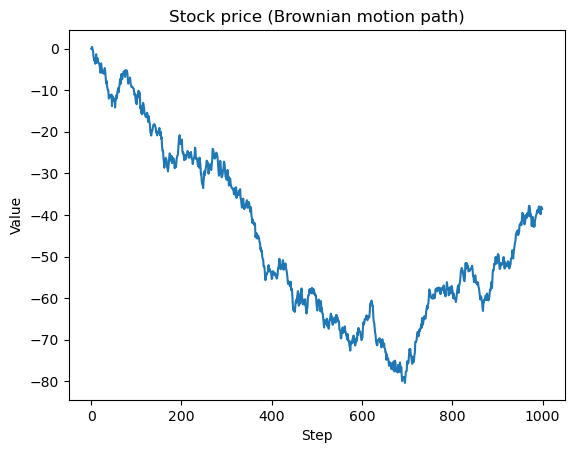

In [246]:
def brownian_motion(num_steps, delta_t, sigma):
    """
    Generate a Brownian motion path.

    Parameters:
    num_steps (int): Number of steps in the Brownian motion.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increments (sqrt of variance).

    Returns:
    np.array: A numpy array representing the Brownian motion path.
    """
    # Generate random increments from a normal distribution
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), num_steps-1)

    # Set the initial value of the Brownian motion
    start_point = 0

    # Compute the Brownian motion path
    return np.cumsum(np.insert(increments, 0, start_point))

# Testing
num_steps = 1000
delta_t = 0.01
sigma = 10

brownian_path = brownian_motion(num_steps, delta_t, sigma)

plt.plot(brownian_path)
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Stock price (Brownian motion path)')
plt.show()


In [247]:
def logistic_threshold_probability(x, threshold):
    """
    Compute the logistic threshold probability with fixed 'a' and 'b' values.

    Parameters:
    x (float): The value at which to compute the probability.
    threshold (float): The threshold value for scaling.

    Returns:
    float: The logistic threshold probability.
    """
    a = 1
    b = 5
    scaled_x = x * (10 / threshold)
    return 1 - 1 / (1 + np.exp(-a * (scaled_x - b)))

In [248]:
def sum_absolute_edge_weights(graph):
    """
    Sums the absolute values of the edge weights in a NetworkX graph.

    :param graph: A NetworkX graph with weighted edges.
    :return: The sum of the absolute values of the edge weights.
    """
    # Initialize the sum to zero
    total_weight = 0

    # Iterate over all edges in the graph
    for (u, v, weight) in graph.edges(data='weight'):
        # Sum the absolute values of the edge weights
        total_weight += abs(weight)

    return total_weight

In [249]:
def simulate_brownian_motion_one_step(exposures, delta_t, sigma):
    """
    Simulate Brownian motion for each agent's exposure for one step.

    Parameters:
    exposures (np.array): Initial exposures of the agents.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increment.

    Returns:
    np.array: Updated exposures after one step of Brownian motion simulation.
    """
    # Generate random increments from a normal distribution for one step
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), len(exposures))

    # Update exposures with the increments
    updated_exposures = exposures + increments
    return updated_exposures

In [250]:
def generate_exposures(N, mu=0, sigma=1):
    """
    Generate a random set of exposures for N agents.

    Parameters:
    N (int): Number of agents.

    Returns:
    np.array: A numpy array representing the exposures of the agents.
    """
    return np.random.normal(-1, 1, N)

In [251]:
def create_directional_graph(N_Nodes, edges=None):
    """
    Creates a directed graph using NetworkX and initializes 'exposure' attribute for each node.

    Parameters:
    N_Nodes (int): The number of nodes in the graph.
    edges (list of tuples, optional): A list of edges to add to the graph.

    Returns:
    nx.DiGraph: A NetworkX directed graph with initialized 'exposure' attribute for each node.
    """
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(N_Nodes))

    # Initialize 'exposure' for each node and 'connected_this_timestep' to False
    exposures = generate_exposures(N_Nodes)
    for node, exposure in zip(G.nodes(), exposures):
        G.nodes[node]['exposure'] = exposure
        G.nodes[node]['connected_this_timestep'] = False


    # Add edges if provided
    if edges is not None:
        for edge in edges:
            G.add_edge(*edge)  # Unpack the tuple for adding an edge

    return G

Agents are willing to link if their summed exposure is small, because then it brings their new exposure closer to 0. The new exposure $E_{i_{t+1}}$ is a random draw between -1 and 1.

If a node cannot find any other node to link with (Due to threshold or or because there are simply no nodes to link with) 

then becomes $E_{i_{t}}$ + the column and row sums of the adjacency matrix. 

In [252]:
# working ver
def form_links_and_update_exposures(G: nx.DiGraph, linking_threshold: float, mode = 'devide exposure equally', max_one_connection_per_node=True, swap_exposure_threshold=0, time_to_maturity=0, link_threshold_mode = 'hard cutoff') -> nx.DiGraph:
    """
    This function forms links between nodes in a directed graph based on the nodes' exposure values and a specified linking threshold.
    It also updates the exposure values of these nodes according to the linking mode.

    In 'devide exposure equally' mode, the sum of the exposures of both nodes involved in a link is evenly distributed to each node.
    This means that after linking, each node will have an exposure value equal to the average of their previous exposures.
    The weight of the link created is based on the change in exposure of the nodes as a result of this process.

    In 'devide exposure singly' mode, one node's exposure is set to zero and the other node receives the entire sum of both exposures.
    This mode is not detailed in the docstring as it is less frequently used.

    Parameters:
    G (nx.DiGraph): The graph to which the nodes belong. Each node should have an 'exposure' and a 'connected_this_timestep' attribute.
    linking_threshold (float): The threshold below which the absolute sum of exposures will trigger a link formation.
    mode (str): The mode of exposure division. Defaults to 'devide exposure equally'.

    Returns:
    nx.DiGraph: The updated graph with new links and updated exposures.
    """

    if linking_threshold == 0:
        linking_threshold = sys.float_info.epsilon



    for i in G.nodes:
        closest_sum = np.inf
        closest_node = None


        if max_one_connection_per_node:

            if not G.nodes[i]['connected_this_timestep']:
                for j in G.nodes:
                    if not G.nodes[j]['connected_this_timestep'] and i != j and G.nodes[i]['exposure'] * G.nodes[j]['exposure'] < 0:
                        sum_of_exposures = G.nodes[i]['exposure'] + G.nodes[j]['exposure']
                        
                        if link_threshold_mode == 'hard cutoff':
                            if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and (np.abs(sum_of_exposures) < linking_threshold):
                                closest_sum = sum_of_exposures
                                closest_node = j
                        if link_threshold_mode == 'logistic':
                            if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and (logistic_threshold_probability(np.abs(sum_of_exposures), linking_threshold) > np.random.random()):
                                closest_sum = sum_of_exposures
                                closest_node = j

        else:
                for j in G.nodes:
                    if i != j and G.nodes[i]['exposure'] * G.nodes[j]['exposure'] < 0:
                        sum_of_exposures = G.nodes[i]['exposure'] + G.nodes[j]['exposure']

                        if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and ((np.abs(sum_of_exposures) < linking_threshold)):
                            closest_sum = sum_of_exposures
                            closest_node = j


    

        if closest_node and (G.nodes[i]['exposure'] > swap_exposure_threshold):

            # deviding the exposure singly means one node gets 0 exposure and the other node gets the remaining exposure
            if mode == 'devide exposure singly':

                # Calculate hedge value based on the smaller absolute exposure of the two nodes
                hedge_value = min(abs(G.nodes[i]['exposure']), abs(G.nodes[closest_node]['exposure']))

                # Determine the sign of the weight for each edge based on the exposure of the originating node
                weight_i_to_closest_node = np.sign(G.nodes[i]['exposure']) * hedge_value
                weight_closest_node_to_i = np.sign(G.nodes[closest_node]['exposure']) * hedge_value

                # Create edges with weights having signs corresponding to the exposure of the originating node
                G.add_edge(i, closest_node, weight=weight_i_to_closest_node, time_to_maturity=time_to_maturity)
                G.add_edge(closest_node, i, weight=weight_closest_node_to_i, time_to_maturity=time_to_maturity)
                G.nodes[i]['exposure'] -= weight_i_to_closest_node
                G.nodes[closest_node]['exposure'] -= weight_closest_node_to_i
                
                
                # Setting the connection flag for both nodes
                G.nodes[i]['connected_this_timestep'] = True
                G.nodes[closest_node]['connected_this_timestep'] = True





            # deviding the exposure equally means that the sum of the exposure of both nodes is evenly distributed to each node.
            if mode == 'devide exposure equally':
                # Calculate the average exposure to evenly divide between the two nodes
                average_exposure = (G.nodes[closest_node]['exposure'] + G.nodes[i]['exposure']) / 2
                # Determine the weight of the link based on the change in exposure
                weight = G.nodes[i]['exposure'] - average_exposure
                # Update exposures and add weighted edges
                G.nodes[i]['exposure'] = average_exposure
                G.nodes[closest_node]['exposure'] = average_exposure
                G.add_edge(i, closest_node, weight=weight, time_to_maturity=time_to_maturity)
                G.add_edge(closest_node, i, weight=-weight, time_to_maturity=time_to_maturity)
                
                # Setting the connection flag for both nodes
                G.nodes[i]['connected_this_timestep'] = True
                G.nodes[closest_node]['connected_this_timestep'] = True

                
                
    # Resetting the flag for the next timestep
                
    if max_one_connection_per_node:
        for node in G.nodes:
            G.nodes[node]['connected_this_timestep'] = False


                

    return G

In [253]:
def draw_graph_with_edge_weights(G, pos=None, node_size=700, node_color='skyblue', font_size=14, 
                                 font_weight='bold', arrowstyle='-|>', arrowsize=20, width=2, 
                                 edge_precision=3):
    """
    Draw a directed graph with edge weights rounded to a specified precision.

    Parameters:
    G (nx.DiGraph): The directed graph to draw.
    pos (dict): Position coordinates for nodes for specific layout.
    node_size (int): Size of nodes.
    node_color (str): Color of nodes.
    font_size (int): Font size for node labels.
    font_weight (str): Font weight for node labels.
    arrowstyle (str): Style of the arrows.
    arrowsize (int): Size of the arrows.
    width (int): Width of edges.
    edge_precision (int): Decimal precision for edge weights.

    Returns:
    None: Draws the graph with matplotlib.


    Note: mind that this picture is not entirely correct, as the weights are able to carry different exposure values depending on the direction of the edge while only 1 is displayed.
    """

    if pos is None:
        pos = nx.spring_layout(G)  # positions for all nodes

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle=arrowstyle, 
                           arrowsize=arrowsize, width=width)
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_weight=font_weight)

    # Draw edge weights with specified precision
    edge_labels = {e: f'{w:.{edge_precision}f}' for e, w in nx.get_edge_attributes(G, 'weight').items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')  # Turn off the axis
    plt.show()

# Testing the Linking function 

In [254]:
# parameters
N = 4 # Number of agents (nodes)
time_steps = 5  # Number of time steps to simulate

In [255]:
# Test the functions    
Graph_updated = create_directional_graph(N)
initial_exposures = generate_exposures(N)
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)
    exposures_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)
    print(exposures_updated)

timestep 0
DiGraph with 4 nodes and 0 edges
timestep 1
DiGraph with 4 nodes and 0 edges
timestep 2
DiGraph with 4 nodes and 0 edges
timestep 3
DiGraph with 4 nodes and 0 edges
timestep 4
DiGraph with 4 nodes and 0 edges


In [256]:
nx.adjacency_matrix(Graph_updated).todense()

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

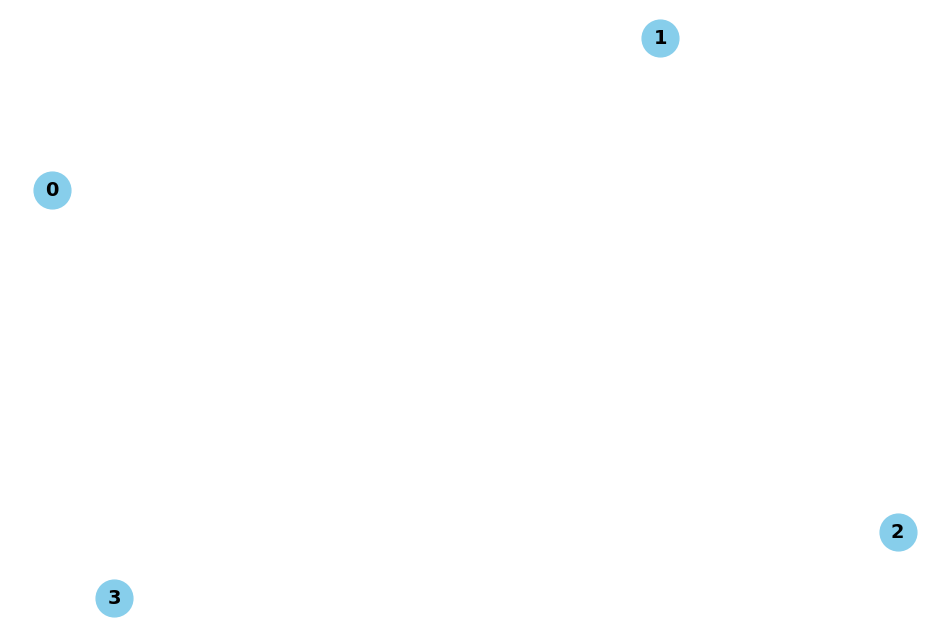

In [257]:
draw_graph_with_edge_weights(Graph_updated)

In [258]:
# Ensure N and time_steps are defined
N = 4  # Number of nodes
time_steps = 5  # Number of time steps

# Initialize the graph and exposures
Graph_updated = create_directional_graph(N)
initial_exposures = [Graph_updated.nodes[i]['exposure'] for i in Graph_updated.nodes]

# Run the simulation for the specified number of time steps
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)

    # Print the current state of the graph
    print(len(Graph_updated.edges()), 'edges')
    print('Current exposures:', [Graph_updated.nodes[i]['exposure'] for i in Graph_updated.nodes])

# Print initial exposures
print('initial_exposures:\n', initial_exposures)

# Generate a weighted adjacency matrix
weighted_adj_matrix = nx.adjacency_matrix(Graph_updated, weight='weight').todense()
print('\nAdjacency matrix: \n', weighted_adj_matrix)

timestep 0
2 edges
Current exposures: [0.7367749569767108, -0.11434935351187103, -2.0985707275553294, -0.11434935351187103]
timestep 1
2 edges
Current exposures: [0.7367749569767108, -0.11434935351187103, -2.0985707275553294, -0.11434935351187103]
timestep 2
2 edges
Current exposures: [0.7367749569767108, -0.11434935351187103, -2.0985707275553294, -0.11434935351187103]
timestep 3
2 edges
Current exposures: [0.7367749569767108, -0.11434935351187103, -2.0985707275553294, -0.11434935351187103]
timestep 4
2 edges
Current exposures: [0.7367749569767108, -0.11434935351187103, -2.0985707275553294, -0.11434935351187103]
initial_exposures:
 [0.7367749569767108, -1.5494985463040403, -2.0985707275553294, 1.3207998392802982]

Adjacency matrix: 
 [[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.43514919]
 [ 0.          0.          0.          0.        ]
 [ 0.          1.43514919  0.          0.        ]]


Number of links at threshold 0.0: 0
Number of links at threshold 0.1: 0
Number of links at threshold 0.2: 0
Number of links at threshold 0.3: 0
Number of links at threshold 0.4: 0
Number of links at threshold 0.5: 0
Number of links at threshold 0.6: 0
Number of links at threshold 0.7: 0
Number of links at threshold 0.8: 0
Number of links at threshold 0.9: 0


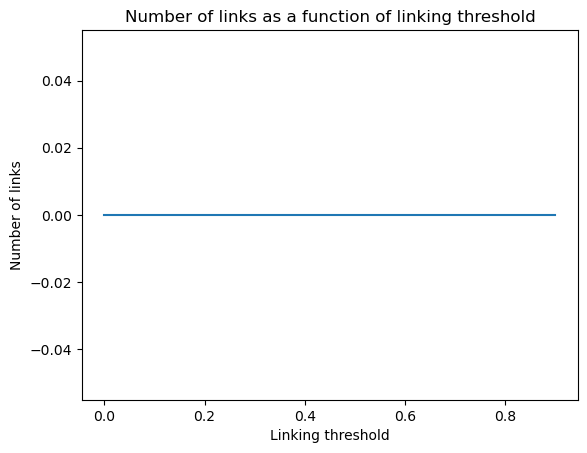

In [259]:
# This cell is purely for testing expected behavior, we expect the number of links to go up as the linking threshold decreases
Graph = create_directional_graph(N_Nodes = 10)
Links_test = []
Link_test_thresholds = []

for i in range(10):
    Graph_updates = form_links_and_update_exposures(G=Graph, linking_threshold=i/10)
    print(f'Number of links at threshold {i/10}: {len(Graph_updates.edges)}')
    Links_test.append(len(Graph_updates.edges))
    Link_test_thresholds.append(i/10)
plt.ylabel('Number of links')
plt.xlabel('Linking threshold')
plt.title('Number of links as a function of linking threshold')
plt.plot(Link_test_thresholds, Links_test)
plt.show()


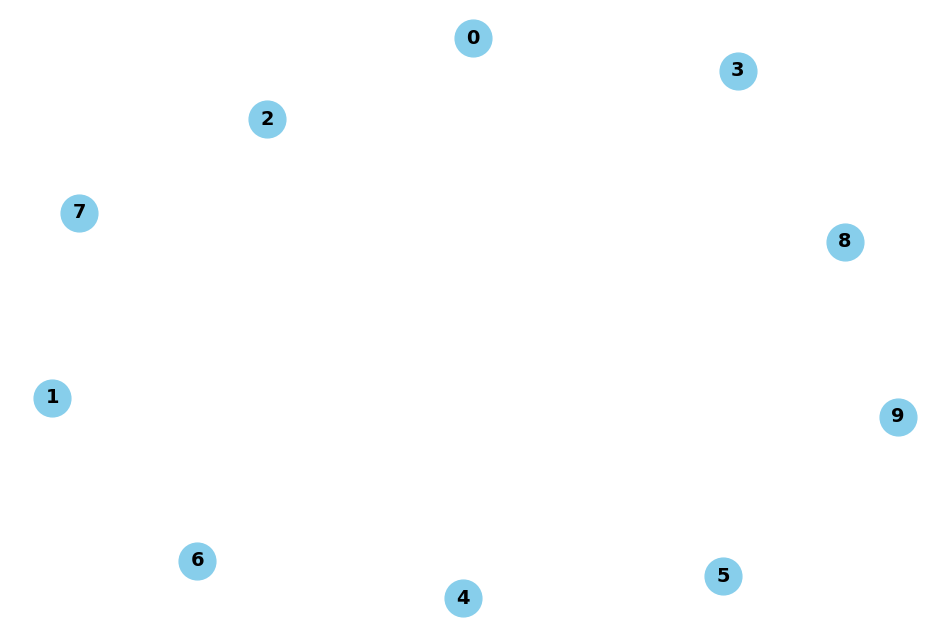

In [260]:
# Amount of links looks to be the same as expected, considering that the links go times 2 because the directional nature of the graph

draw_graph_with_edge_weights(Graph_updates)

# Extending the framework

We need logic to account for when a node dies and what then happens to the exposure of the other nodes, the function below does this:

In [261]:
# Modified, time to maturity now added.
def check_bankruptcy_and_update_network(G, threshold_v, delta_price, create_new_node_mode=True):
    """
    Analyze a network of nodes (represented by a graph) to identify and process bankrupt nodes based on a volatility threshold.
    This function updates the exposures of nodes in the network, identifies bankrupt nodes, redistributes their exposures to neighbors,
    and optionally adds new nodes to the network.

    :param G: The graph representing the network of nodes.
    :param threshold_v: The threshold for volatility, above which a node is considered bankrupt.
    :param delta_price: The change in price, used to calculate volatility.
    :param create_new_node_mode: Flag to determine whether to create a new node for each bankrupt node removed.
    :return: A tuple containing the updated graph and the number of bankruptcies identified.
    """
    bankrupt_nodes = set()
    num_bankruptcies = 0
    edges_to_remove = []
    edges_to_decrement = []

    # Process edges with zero time to maturity
    for u, v, attr in G.edges(data=True):
        time_to_maturity = attr.get('time_to_maturity', 0)  # Assuming default time_to_maturity is 1 if not present

        if time_to_maturity == 0:
            exposure_u = G.nodes[u]['exposure']
            exposure_v = G.nodes[v]['exposure']
            weight = attr['weight']

            # Adjust exposures considering the directionality
            G.nodes[u]['exposure'] = exposure_u - weight
            G.nodes[v]['exposure'] = exposure_v + weight

            # Mark the edge for removal
            edges_to_remove.append((u, v))
        else:
            # Mark the edge for decrementing time to maturity
            edges_to_decrement.append((u, v, time_to_maturity))

    # Remove marked edges
    for u, v in edges_to_remove:
        G.remove_edge(u, v)
        

    # Decrement time to maturity for marked edges
    for u, v, time_to_maturity in edges_to_decrement:
        G.edges[u, v]['time_to_maturity'] = max(0, time_to_maturity - 1)



    # Update exposures based on volatility and identify bankrupt nodes
    for node in G.nodes():
        exposure = G.nodes[node].get('exposure', 0)  # Get exposure from node, defaulting to 0 if not present
        volatility = exposure * delta_price
        if abs(volatility) > threshold_v:
            bankrupt_nodes.add(node)
            num_bankruptcies += 1

    # Process bankrupt nodes
    for node in bankrupt_nodes:
        if node in G:
            # Redistribute exposure to neighbors
            for neighbor in G.neighbors(node):
                if neighbor not in bankrupt_nodes:
                    neighbor_exposure = G.nodes[neighbor].get('exposure', 0)
                    G.nodes[neighbor]['exposure'] = neighbor_exposure + G.edges[neighbor, node]['weight']

            # Remove bankrupt node
            G.remove_node(node)

            if create_new_node_mode:
                # Create new node
                new_node_id = max(G.nodes())+1 if G.nodes() else 0
                G.add_node(new_node_id, exposure=0, connected_this_timestep=False)


    return G, num_bankruptcies

In [262]:
# # Test check_bankruptcy_and_update_network to verify that the exposure of neighbour node has been updated as expected after one node is bankrupt

# def test_bankruptcy_and_exposure_update():
#     # Create a small test graph
#     G = nx.DiGraph()
#     G.add_node(0, exposure=20)  # Add a node that will go bankrupt
#     G.add_node(1, exposure=4)   # Add a node connected to the bankrupt node
#     G.add_node(2, exposure=-2)  # Add another unrelated node
#     G.add_edge(1, 0, weight=4)  # Link between bankrupt node and node 1
#     G.add_edge(0, 1, weight=-5) # Link in the opposite direction
#     # Define test parameters
#     threshold_v = 10  # Bankruptcy threshold
#     delta_price = 1.5 # Price fluctuation

#     # Apply the function
#     G, num_bankruptcies = check_bankruptcy_and_update_network(G, threshold_v, delta_price)

#     # Verify that the bankrupt node has been removed
#     assert 0 not in G

#     # Verify that the exposure of node 1 has been updated as expected
#     expected_exposure = 4 + 4  # Original exposure + weight of the bankrupt node
#     print('expected_exposure:', expected_exposure)
#     actual_exposure = G.nodes[1]['exposure']
#     print('actual_exposure:', actual_exposure)
#     assert actual_exposure == expected_exposure

#     # Verify the number of bankruptcies
#     assert num_bankruptcies == 1

#     # Verify that other nodes are unaffected
#     assert G.nodes[2]['exposure'] == -2

#     print("All tests passed")

# # Run the test function
# test_bankruptcy_and_exposure_update()

In [263]:
def calculate_first_order_differences(array):
    """
    Calculate the first order differences of a numpy array.

    Parameters:
    array (np.array): The input array.

    Returns:
    np.array: The first order differences of the input array.
    """
    return np.diff(array)


A simulation function putting it all together

In [264]:
def financial_network_simulator(N_agents, num_steps, delta_t, sigma_exposure_node, sigma_intrestrate, threshold_v, linking_threshold, swap_exposure_threshold=0.5, print_timestep=True, time_to_maturity=0, link_threshold_mode = 'hard cutoff'):
    """
    Simulates a financial network over a specified number of time steps. 

    The simulation includes dynamic changes in agent exposures and inter-agent connections, 
    influenced by a stochastic process (Brownian motion). The network evolves through
    the formation of new links and the possibility of bankruptcy among agents.

    Parameters:
    - N_agents (int): Number of agents in the network.
    - num_steps (int): Number of time steps for the simulation.
    - delta_t (float): Time step size for Brownian motion.
    - sigma_exposure_node (float): Standard deviation for exposure changes of each agent.
    - sigma_intrestrate (float): Standard deviation for interest rate changes in Brownian motion.
    - threshold_v (float): Threshold value for bankruptcy determination.
    - linking_threshold (float): Threshold for forming new links between agents.
    - print_timestep (bool, optional): Flag to print the current time step (default is True).

    Returns:
    tuple: A tuple containing:
        - The final graph of the network.
        - Array of summed absolute exposures over time.
        - Array of the cumulative number of bankrupt agents over time.
        - Array of simulated prices (interest rates).
        - Array of the number of links over time.
        - Array of total absolute exposure in edge weights over time.
        - Array of node population over time.
    """
    # Initialize graph with nodes having exposure attributes
    graph = create_directional_graph(N_agents)



    # Initialize 'connected_this_timestep' flag to false for each node
    for i in range(N_agents):
        graph.nodes[i]['connected_this_step'] = False
    


    # Simulate interest rate as Brownian motion
    simulated_prices = brownian_motion(num_steps, delta_t, sigma_intrestrate)

    # Calculate price movement difference for each step
    delta_price_array = calculate_first_order_differences(simulated_prices)

    # Arrays to track metrics over time
    num_bankrupt_agents_total = 0
    num_bankrupt_agents_over_time = np.zeros(num_steps)
    links_over_time = np.zeros(num_steps)
    abs_exposures_over_time_summed = np.zeros(num_steps)
    total_abs_exposure_in_edge_weights = np.zeros(num_steps)
    node_population_over_time = np.zeros(num_steps)

    # Simulate over time
    for step in range(num_steps):

        if print_timestep:
            print('timestep', step)

        # Update exposures based on Brownian motion
        for i in graph.nodes():
            graph.nodes[i]['exposure'] += np.random.normal(0, sigma_exposure_node * delta_t)

        # Form links and update exposures based on the current state
        # graph = form_links_and_update_exposures(graph, linking_threshold, swap_exposure_threshold)
        graph = form_links_and_update_exposures(graph, linking_threshold, time_to_maturity=time_to_maturity, swap_exposure_threshold=swap_exposure_threshold, link_threshold_mode = link_threshold_mode)


        # Check for bankruptcy and update the network
        graph, bankruptcies_this_step = check_bankruptcy_and_update_network(graph, threshold_v, delta_price_array[step-1])



        # Add the number of bankruptcies this step to the total
        num_bankrupt_agents_total += bankruptcies_this_step
        

        # Update the number of bankruptcies over time
        num_bankrupt_agents_over_time[step] = num_bankrupt_agents_total



        # Update the number of links over time
        links_over_time[step] = graph.number_of_edges()

        # Update the sum of absolute exposures over time
        abs_exposures_over_time_summed[step] = np.sum(np.abs(np.array(list(nx.get_node_attributes(graph, 'exposure')))))

        # Update exposures over time
        abs_exposure_in_edge_weights = sum_absolute_edge_weights(graph)

        total_abs_exposure_in_edge_weights[step] = abs_exposure_in_edge_weights

        # Update node population over time

        node_population_over_time[step] = len(graph.nodes())



        

    return graph, abs_exposures_over_time_summed, num_bankrupt_agents_over_time, simulated_prices, links_over_time, total_abs_exposure_in_edge_weights, node_population_over_time

# First run

In [265]:
# Parameters for the simulation
N_agents = 100
num_steps = 2000# Number of simulation steps
delta_t = 0.01  # Time increment for Brownian motion
sigma_exposure_node = 2  # Standard deviation for Brownian motion
sigma_intrestrate = 100
threshold_v = 2  # Bankruptcy threshold
linking_threshold = 2 # Threshold for forming links
swap_exposure_threshold = 0
Node_creation_mode = True
time_to_maturity = 50
link_threshold_mode = 'hard cutoff'



# running time 1 pass with these params: 900 seconds

# Running the simulator
graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time, total_abs_exposure_in_edge_weights, node_population_over_time = financial_network_simulator(N_agents = N_agents, num_steps = num_steps, sigma_exposure_node = sigma_exposure_node, sigma_intrestrate = sigma_intrestrate, delta_t = delta_t, threshold_v = threshold_v, linking_threshold = linking_threshold, swap_exposure_threshold = swap_exposure_threshold, time_to_maturity = time_to_maturity , link_threshold_mode = link_threshold_mode)
# graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time, total_abs_exposure_in_edge_weights, node_population_over_time = financial_network_simulator(N_agents = N_agents, num_steps = num_steps, sigma_exposure_node = sigma_exposure_node, sigma_intrestrate = sigma_intrestrate, delta_t = delta_t, threshold_v = threshold_v, linking_threshold = linking_threshold)

timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31
timestep 32
timestep 33
timestep 34
timestep 35
timestep 36
timestep 37
timestep 38
timestep 39
timestep 40
timestep 41
timestep 42
timestep 43
timestep 44
timestep 45
timestep 46
timestep 47
timestep 48
timestep 49
timestep 50
timestep 51
timestep 52
timestep 53
timestep 54
timestep 55
timestep 56
timestep 57
timestep 58
timestep 59
timestep 60
timestep 61
timestep 62
timestep 63
timestep 64
timestep 65
timestep 66
timestep 67
timestep 68
timestep 69
timestep 70
timestep 71
timestep 72
timestep 73
timestep 74
timestep 75
timestep 76
timestep 77
timestep 78
timestep 79
timestep 80
timestep 81
timestep 82
timestep 83
ti

timestep 100
timestep 101
timestep 102
timestep 103
timestep 104
timestep 105
timestep 106
timestep 107
timestep 108
timestep 109
timestep 110
timestep 111
timestep 112
timestep 113
timestep 114
timestep 115
timestep 116
timestep 117
timestep 118
timestep 119
timestep 120
timestep 121
timestep 122
timestep 123
timestep 124
timestep 125
timestep 126
timestep 127
timestep 128
timestep 129
timestep 130
timestep 131
timestep 132
timestep 133
timestep 134
timestep 135
timestep 136
timestep 137
timestep 138
timestep 139
timestep 140
timestep 141
timestep 142
timestep 143
timestep 144
timestep 145
timestep 146
timestep 147
timestep 148
timestep 149
timestep 150
timestep 151
timestep 152
timestep 153
timestep 154
timestep 155
timestep 156
timestep 157
timestep 158
timestep 159
timestep 160
timestep 161
timestep 162
timestep 163
timestep 164
timestep 165
timestep 166
timestep 167
timestep 168
timestep 169
timestep 170
timestep 171
timestep 172
timestep 173
timestep 174
timestep 175
timestep 176

# Visual tests of network behavior

In [266]:
def plot_financial_network_results(time_steps, num_bankrupt_agents_over_time, node_population_over_time, links_over_time, total_abs_exposure_in_edge_weights, exposures_over_time, simulated_prices):

    time_steps = np.arange(num_steps)

     # Calculate network density for each time step
    network_density_over_time = [links_over_time[t] / (node_population_over_time[0] * (node_population_over_time[0] - 1)) for t in range(len(time_steps))]

    # Calculate the difference in the number of bankrupt agents
    diff_bankrupt_agents = np.diff(num_bankrupt_agents_over_time)

    # Create a large figure to hold all subplots
    plt.figure(figsize=(12, 24))

    # Subplot 1: Number of Bankrupt Agents Over Time
    plt.subplot(5, 2, 1)
    plt.plot(time_steps, num_bankrupt_agents_over_time, label='Number of Bankrupt Agents')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Bankrupt Agents')
    plt.title('Number of Bankrupt Agents Over Time')
    plt.legend()

    # Subplot 2: Difference in Number of Bankrupt Agents
    plt.subplot(5, 2, 2)
    plt.plot(time_steps[1:], diff_bankrupt_agents, label='Difference in Bankrupt Agents', color='orange')
    plt.xlabel('Time Step')
    plt.ylabel('Difference in Number of Bankrupt Agents')
    plt.title('Difference in Number of Bankrupt Agents Over Time')
    plt.legend()


    # Subplot 3: Cumulative Histogram (in reverse order) of Difference in Bankrupt Agents in Log-Log scale
    plt.subplot(5, 2, 3)
    plt.hist(np.abs(diff_bankrupt_agents), bins=50, cumulative=-1, log=True, color='green', label='Cumulative Histogram of Diff in Bankrupt Agents', histtype='step')
    plt.xscale('log')
    plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
    plt.ylabel('Cumulative Count (Log Scale)')
    plt.title('Cumulative Histogram of Difference in Number of Bankrupt Agents Over Time')
    plt.legend()


    # Subplot 4: Simulated Prices Over Time
    plt.subplot(5, 2, 4)
    plt.plot(time_steps, simulated_prices, label='Simulated Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.title('Simulated Prices Over Time')
    plt.legend()

    # Subplot 5: Number of Nodes Over Time
    plt.subplot(5, 2, 5)
    plt.plot(time_steps, node_population_over_time, label='Number of Nodes')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Nodes')
    plt.title('Number of Nodes Over Time')
    plt.legend()

    # Subplot 6: Number of Links in the Network Over Time
    plt.subplot(5, 2, 6)
    plt.plot(time_steps, links_over_time, label='Number of Links in the Network')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Links')
    plt.title('Number of Links in the Network Over Time')
    plt.legend()

    # Subplot 7: Summed abs(Exposure) stored in links of All Agents Over Time
    plt.subplot(5, 2, 7)
    plt.plot(time_steps, total_abs_exposure_in_edge_weights, label='Total abs Exposure in Links')
    plt.xlabel('Time Step')
    plt.ylabel('Total abs Exposure stored in links')
    plt.title('Summed abs(Exposure) stored in links of All Agents Over Time')
    plt.legend()

    # Subplot 8: Summed Exposure of All Agents Node exposure Over Time
    plt.subplot(5, 2, 8)
    plt.plot(time_steps, exposures_over_time, label='Summed Exposure')
    plt.xlabel('Time Step')
    plt.ylabel('Total Exposure')
    plt.title('Summed Exposure of All Agents Node exposure Over Time')
    plt.legend()

    # Subplot 9: Network Density Over Time
    plt.subplot(5, 2, 9)
    plt.plot(time_steps, network_density_over_time, label='Network Density')
    plt.xlabel('Time Step')
    plt.ylabel('Network Density')
    plt.title('Network Density Over Time')
    plt.legend()


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

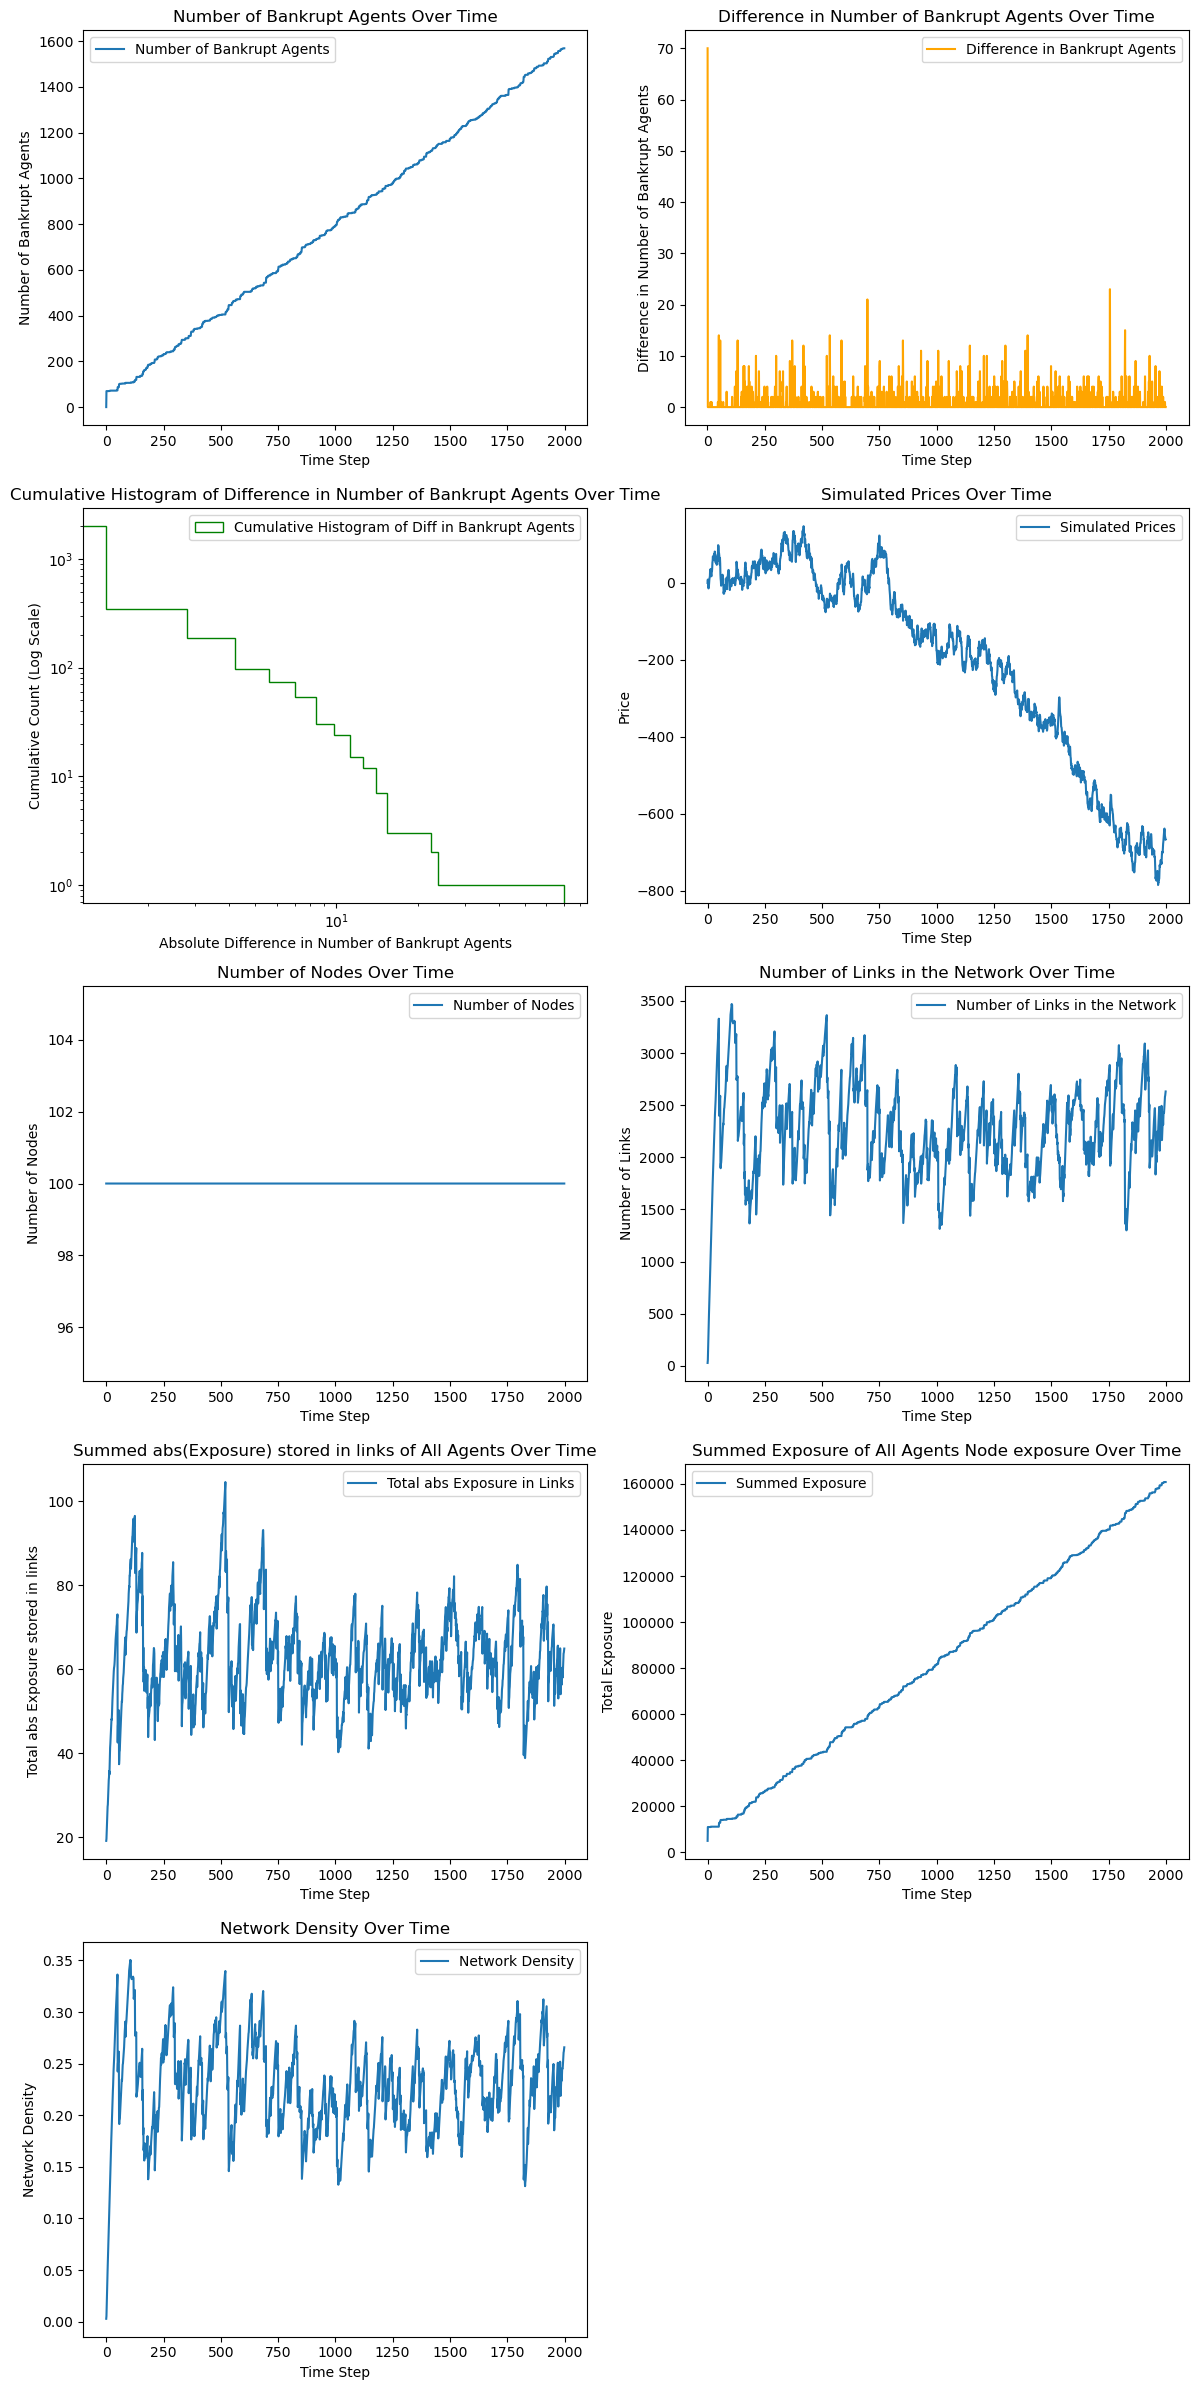

In [267]:
plot_financial_network_results(num_steps, num_bankrupt_agents_over_time, node_population_over_time, links_over_time, total_abs_exposure_in_edge_weights, exposures_over_time, simulated_prices)

In [269]:
# in progress.. not yet done. Function for plot of experiment 3

def plot_3d_probability_default_surface(time_steps, prob_of_default, default_size, total_abs_exposure_in_edge_weights):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Creating grid values for interpolation
    X, Y = np.meshgrid(np.linspace(prob_of_default.min(), prob_of_default.max(), 100),
                       np.linspace(default_size.min(), default_size.max(), 100))
    
    # Interpolating Z values (total_abs_exposure_in_edge_weights) on the grid
    Z = griddata((prob_of_default, default_size), total_abs_exposure_in_edge_weights, (X, Y), method='linear')

    # Creating the surface plot
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    # Adding labels and title
    ax.set_xlabel('Probability of Default')
    ax.set_ylabel('Default Size')
    ax.set_zlabel('Max Abs Exposure')
    ax.set_title('3D Surface Plot of Probability of Default vs Default Size vs Max Abs Exposure')

    # Adding a color bar to represent total_abs_exposure_in_edge_weights
    cbar = plt.colorbar(surf)
    cbar.set_label('Max Abs Exposure')

    plt.show()

# Hypothesis tests


In [270]:
def hill_estimator(data, percentage_of_tail):
    """
    Computes the Hill Estimator for a given one-dimensional dataset.
    """

    # Remove nans and 0s
    data = data[~np.isnan(data)]
    data = data[data != 0]
    
    # Arrange the dataset in ascending order:
    sorted_data = np.sort(data)
    total_elements = len(sorted_data)
    k = int(np.round((percentage_of_tail * total_elements) / 100))
    log_value_at_n_minus_k = np.log(sorted_data[total_elements - k - 1])
    log_values_in_tail = np.log(sorted_data[-k:])

    estimated_alpha = k * (np.sum(log_values_in_tail - log_value_at_n_minus_k)) ** -1

    return estimated_alpha

In [271]:
# Fit the data to a power-law distribution
def fit_power_law(data: np.ndarray, percentage_of_tail = 10) -> Tuple[float, float]:
    """
    Fit a given dataset to a power-law distribution, plot the Probability Density Function (PDF) 
    for both the empirical data and the power-law fit, and compare it with an exponential distribution.

    This function uses the powerlaw package to fit the data and matplotlib for plotting. It also
    calculates the goodness of the fit by comparing the power-law distribution with an exponential
    distribution using a loglikelihood ratio test and reports the statistical significance.

    Parameters:
    data (np.ndarray): A one-dimensional Numpy array of the data to be fitted.

    Returns:
    Tuple[float, float]: A tuple containing the loglikelihood ratio (R) and the p-value (p) of the
    comparison between the power-law and exponential distributions. If R > 0 and p < 0.05, the data
    is better explained by a power-law distribution.
    """
    results = powerlaw.Fit(data)
    
    # Plot the PDF and compare it to the power-law.
    plt.figure(figsize=(12, 8))
    results.power_law.plot_pdf(color='b', linestyle='--', label='Power-law fit')
    results.plot_pdf(color='b', label='Empirical Data')
    plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
    plt.ylabel('Probability Density Function (PDF)')
    plt.title('PDF and Power-law Fit of the Data')
    plt.legend()
    plt.show()

    # Calculate the goodness of fit
    R, p = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    
    # Output the loglikelihood ratio and p-value
    print(f"Loglikelihood ratio between power law and exponential distribution: {R}")
    print(f"Statistical significance of the fit (p-value): {p}")

    # Conclusion based on the loglikelihood ratio and p-value
    if R > 0 and p < 0.05:
        print("The data follows a power-law distribution better than an exponential distribution.")
        print("\n")

        print(f"According to Hills estimate looking at {percentage_of_tail} of values in the tail of the distribution, the alpha estimate is is:", hill_estimator(data = data, percentage_of_tail = percentage_of_tail))
    else:
        print("There is not sufficient evidence to conclude that the data follows a power-law distribution better than an exponential distribution.")

    return R, p

**Does the bankruptcy per step follow powerlaw distribution?**

Null Hypothesis (H0): The data follows an exponential distribution as well as or better than a power-law distribution.

Alternative Hypothesis (H1): The data follows a power-law distribution better than an exponential distribution.

In [272]:
diff_bankrupt_agents = np.diff(num_bankrupt_agents_over_time)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


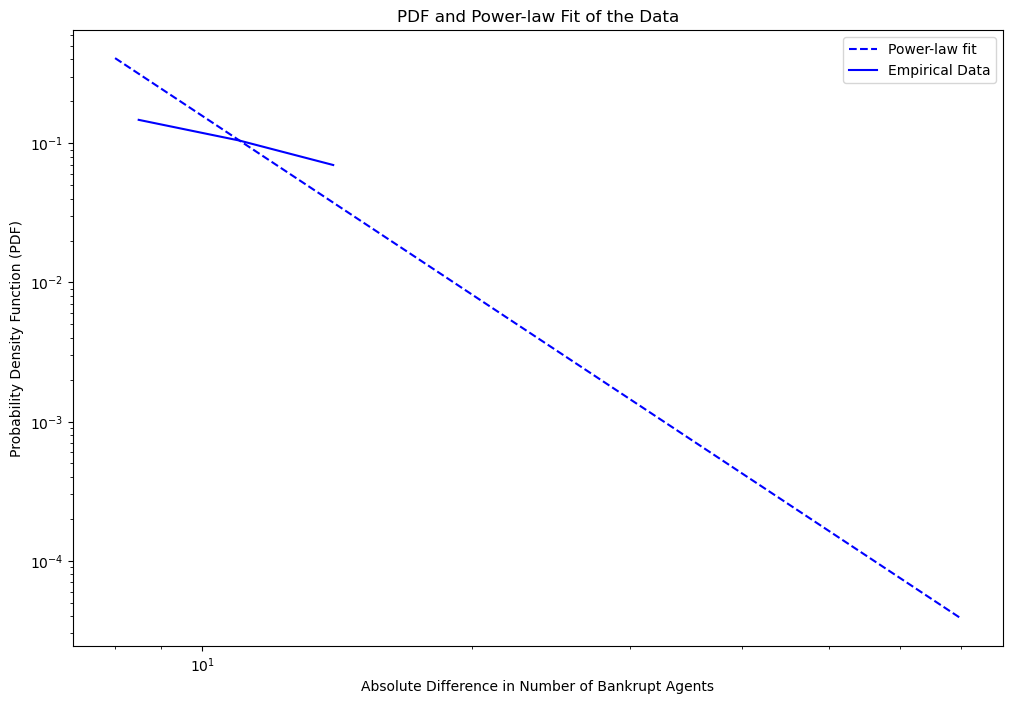

Loglikelihood ratio between power law and exponential distribution: 1.506584090778581
Statistical significance of the fit (p-value): 0.1319172978279755
There is not sufficient evidence to conclude that the data follows a power-law distribution better than an exponential distribution.


(1.506584090778581, 0.1319172978279755)

In [273]:
fit_power_law(np.abs(diff_bankrupt_agents))

# Multiple run simulator

In [274]:


def save_results_to_csv(run_results, combination):
    """
    Saves the results of a simulation run to a CSV file.

    This function takes the results of a financial network simulation for a given parameter combination,
    converts the results into a tabular format, and saves them as a CSV file. The filename is generated 
    based on the parameter combination and the current timestamp to ensure uniqueness. Complex data types 
    like graphs are not included. Data like numpy arrays are converted to string representations for storage.

    Parameters:
    run_results (list of dicts): A list of dictionaries where each dictionary contains the results of a 
                                 single simulation run for the given parameter combination.
    combination (tuple): A tuple representing the parameter combination for these simulation runs. This 
                         is used to generate the filename.

    The function does not return any value but saves a CSV file in the current working directory.
    """
    # Create a DataFrame from the results
    df = pd.DataFrame()
    for i, result in enumerate(run_results):
        df.at[i, 'Run'] = i + 1
        df.at[i, 'Exposures Over Time'] = str(result['abs_exposures_over_time_summed'].tolist())
        df.at[i, 'Number of Bankrupt Agents Over Time'] = str(result['num_bankrupt_agents_over_time'].tolist())
        df.at[i, 'Simulated Prices'] = str(result['simulated_prices'].tolist())
        df.at[i, 'Links Over Time'] = str(result['links_over_time'].tolist())
        df.at[i, 'Total Absolute Exposure in Edge Weights'] = str(result['total_abs_exposure_in_edge_weights'].tolist())
        df.at[i, 'Node Population Over Time'] = str(result['node_population_over_time'].tolist())

    # Create a unique filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    filename = "_".join(map(str, combination)) + "_" + timestamp + ".csv"

    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Saved results to {filename}")

In [275]:
def save_all_results_to_csv(all_results):
    # Create a DataFrame to store all results
    all_df = pd.DataFrame()

    for combination, run_results in all_results.items():
        for i, result in enumerate(run_results):
            row = {'Combination': combination, 'Run': i + 1}
            row.update({key: str(value) for key, value in result.items() if key != 'graph'})  # Excluding graph object
            all_df = all_df.append(row, ignore_index=True)

    # Create a unique filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    filename = "simulation_results_" + timestamp + ".csv"

    # Save to CSV
    all_df.to_csv(filename, index=False)
    print(f"Saved all results to {filename}")

In [276]:
def multi_parameter_financial_network_simulator(runs, N_agents_list, num_steps_list, delta_t_list, sigma_exposure_node_list, sigma_intrestrate_list, threshold_v_list, linking_threshold_list):
    """
    Runs multiple simulations of a financial network simulator for all combinations of given parameter lists. 
    Each simulation is run a specified number of times ('runs') for each combination of parameters.

    Parameters:
    runs (int): The number of times to run the simulation for each combination of parameters.
    N_agents_list (list of int): List of numbers representing the number of agents in the simulation.
    num_steps_list (list of int): List of numbers representing the number of steps in each simulation.
    delta_t_list (list of float): List of delta time values for the simulation.
    sigma_list (list of float): List of sigma values for the simulation.
    threshold_v_list (list of float): List of threshold values for bankruptcy.
    linking_threshold_list (list of float): List of threshold values for linking agents in the network.

    Returns:
    dict: A dictionary where each key is a tuple representing a combination of parameters, and each value 
    is a list of dictionaries. Each dictionary in the list contains the results of a single run of the 
    simulation for that parameter combination. The result dictionary keys are 'graph', 'exposures_over_time',
    'num_bankrupt_agents_over_time', 'simulated_prices', and 'links_over_time'.

    Example:
    To run simulations for combinations of [100, 150] agents and [50, 60] steps, each for 3 runs:
    results = multi_parameter_financial_network_simulator(3, [100, 150], [50, 60], [0.1], [0.05], [1.0], [0.5])
    
    The structure of the returned dictionary for one combination might look like this:
    {
        (100, 50, 0.1, 0.05, 1.0, 0.5): [
            {
                'graph': <networkx.DiGraph object>,
                'exposures_over_time': numpy.ndarray,
                'num_bankrupt_agents_over_time': numpy.ndarray,
                'simulated_prices': numpy.ndarray,
                'links_over_time': numpy.ndarray
            },
            # ... More runs for the same combination ...
        ],
        # ... More parameter combinations ...
    }
    """
    # Dictionary to store results
    results_dict = {}

    # Generate all combinations of parameters
    param_combinations = itertools.product(N_agents_list, num_steps_list, delta_t_list, sigma_exposure_node_list, sigma_intrestrate_list, threshold_v_list, linking_threshold_list)


    
    param_combinations_list = list(param_combinations)
    total_iterations = len(param_combinations_list) * runs

    # Initialize counter for progress bar
    iteration = 1
    # record start time
    start_time = time.time()


    for combination in param_combinations_list:
        N_agents, num_steps, delta_t, sigma_exposure_node, sigma_intrestrate, threshold_v, linking_threshold = combination
        combination_results = []

        for _ in range(runs):
            result = financial_network_simulator(N_agents, num_steps, delta_t, sigma_exposure_node, sigma_intrestrate, threshold_v, linking_threshold, print_timestep=False)
            
            graph, abs_exposures_over_time_summed, num_bankrupt_agents_over_time, simulated_prices, links_over_time, total_abs_exposure_in_edge_weights, node_population_over_time = result

            run_result = {
                'graph': graph,
                'abs_exposures_over_time_summed': abs_exposures_over_time_summed,
                'num_bankrupt_agents_over_time': num_bankrupt_agents_over_time,

                'simulated_prices': simulated_prices,
                'links_over_time': links_over_time,
                'total_abs_exposure_in_edge_weights': total_abs_exposure_in_edge_weights,
                'node_population_over_time': node_population_over_time
            }
            combination_results.append(run_result)

            # Increment counter for progress bar
            iteration += 1
            current_time = time.time()
            elapsed_time = current_time - start_time
            avg_time_per_iteration = elapsed_time / iteration
            estimated_total_time = avg_time_per_iteration * total_iterations
            time_remaining = estimated_total_time - elapsed_time

            # Format remaining time as hh:mm:ss
            remaining_time_formatted = str(datetime.timedelta(seconds=int(time_remaining)))

            # Print progress with timestamp and estimated completion time
            print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Progress: {iteration}/{total_iterations} ({iteration/total_iterations*100:.2f}%) - Estimated Time Remaining: {remaining_time_formatted}")


        save_results_to_csv(combination_results, combination)



        # Store results for this combination
        results_dict[combination] = combination_results

    # Save to CSV
    save_all_results_to_csv(results_dict)

    return results_dict

In [277]:

# data_of_multirun = multi_parameter_financial_network_simulator(runs=10, N_agents_list=[200,500,1000,2000], num_steps_list=[2000], delta_t_list=[0.01], sigma_exposure_node_list = [0.2,0.5,1],  sigma_intrestrate_list = [16,32,50], threshold_v_list= [1,4,10], linking_threshold_list = [0.5,0.2,0.1,0.01])


# Exploratory Data Analysis Functions

In [278]:
def analyze_network(G):
    # Initialize DataFrame
    stats_df = pd.DataFrame(index=G.nodes())

    # Centralities
    stats_df['Betweenness Centrality'] = pd.Series(nx.betweenness_centrality(G))
    stats_df['Closeness Centrality'] = pd.Series(nx.closeness_centrality(G))
    stats_df['Eigenvector Centrality'] = pd.Series(nx.eigenvector_centrality(G, max_iter=500))

    # Node Degree (In and Out for Directed Graph)
    if G.is_directed():
        stats_df['In-Degree'] = pd.Series(dict(G.in_degree()))
        stats_df['Out-Degree'] = pd.Series(dict(G.out_degree()))
    else:
        stats_df['Degree'] = pd.Series(dict(G.degree()))

    # Diameter and Average Shortest Path Length
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        avg_shortest_path = nx.average_shortest_path_length(G)
        stats_df['Diameter'] = diameter
        stats_df['Average Shortest Path Length'] = avg_shortest_path
    else:
        print("The graph is not connected. Diameter and Average Shortest Path Length cannot be computed.")

    # Plot Degree Distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1, 1))
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    return stats_df

In [279]:
# Used to calculate the volatility (standard deviation) of a time series

def calculate_std_diff(timeseries):
    """
    Calculate the standard deviation of the first-order differences of a time series.

    Parameters:
    timeseries (np.array): A time series data in the form of a NumPy array.

    Returns:
    float: The standard deviation of the first-order differences of the time series.
    """
    return np.std(np.diff(timeseries))

# What we add in comparison to the paper Drupsteen 2019:

- we add a preferential attachment linking mechanism, meaning agens prefer to link with other agents such that the summed exposure is as close to 0 as possible.
- we add exposure to an external asset (intrest rate) instead of just merely looking at exposure. This allows moddeling the effect of price swings on the default cascade probability

# Experiments


In this part of the notebook, we conduct experiments to identify properties of the network. We want to conduct the following experiments

1. Look at the CDF avalanche sizes to see if it is powerlaw

1. Look at the distribution of avalanche sizes vs. system size, to see if it is powerlaw


2. Look at the probability of avalanche as a function of volatility of the price time series


3. Look at stress in the system vs. probability of avalanche vs. volatility of the asset


Possible run params experiment  1, 2 & 3:

data_of_multirun = multi_parameter_financial_network_simulator(runs=10, N_agents_list=[200,500,1000,2000], num_steps_list=[2000], delta_t_list=[0.01], sigma_exposure_node_list = [0.2,0.5,1],  sigma_intrestrate_list = [16,32,50], threshold_v_list= [1,4,10], linking_threshold_list = [0.5,0.2,0.10,0.01])


5. Look at multiple thresholding functions to compare
